In [2]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [3]:
# fix random seed for reproducibility
numpy.random.seed(666)

In [8]:
# load the dataset
dataframe = pandas.read_csv('20171106_CQ148Z14_before.csv')
dataset = dataframe.values
dataset = dataset.astype('float32')

In [9]:
dataset

array([[  8.],
       [ 10.],
       [  8.],
       ..., 
       [  4.],
       [  0.],
       [ 11.]], dtype=float32)

In [10]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [11]:
# split into train and test sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

1309 328


In [12]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [23]:
# reshape into X=t and Y=t+1
look_back = 12
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [24]:
trainX

array([[ 0.05714286,  0.07142857,  0.05714286, ...,  0.03571429,
         0.02857143,  0.03571429],
       [ 0.07142857,  0.05714286,  0.05      , ...,  0.02857143,
         0.03571429,  0.05      ],
       [ 0.05714286,  0.05      ,  0.02142857, ...,  0.03571429,
         0.05      ,  0.06428572],
       ..., 
       [ 0.10714286,  0.02142857,  0.05714286, ...,  0.08571429,
         0.07857143,  0.09285714],
       [ 0.02142857,  0.05714286,  0.05      , ...,  0.07857143,
         0.09285714,  0.07142857],
       [ 0.05714286,  0.05      ,  0.02857143, ...,  0.09285714,
         0.07142857,  0.09285714]], dtype=float32)

In [25]:
trainY

array([ 0.05      ,  0.06428572,  0.00714286, ...,  0.07142857,
        0.09285714,  0.02857143], dtype=float32)

In [26]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [27]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=50, verbose=2)

Epoch 1/50
 - 1s - loss: 0.0342
Epoch 2/50
 - 0s - loss: 0.0213
Epoch 3/50
 - 0s - loss: 0.0160
Epoch 4/50
 - 0s - loss: 0.0145
Epoch 5/50
 - 0s - loss: 0.0140
Epoch 6/50
 - 0s - loss: 0.0136
Epoch 7/50
 - 0s - loss: 0.0132
Epoch 8/50
 - 0s - loss: 0.0129
Epoch 9/50
 - 0s - loss: 0.0125
Epoch 10/50
 - 0s - loss: 0.0122
Epoch 11/50
 - 0s - loss: 0.0120
Epoch 12/50
 - 0s - loss: 0.0117
Epoch 13/50
 - 0s - loss: 0.0115
Epoch 14/50
 - 0s - loss: 0.0114
Epoch 15/50
 - 0s - loss: 0.0112
Epoch 16/50
 - 0s - loss: 0.0111
Epoch 17/50
 - 0s - loss: 0.0110
Epoch 18/50
 - 0s - loss: 0.0109
Epoch 19/50
 - 0s - loss: 0.0109
Epoch 20/50
 - 0s - loss: 0.0107
Epoch 21/50
 - 0s - loss: 0.0107
Epoch 22/50
 - 0s - loss: 0.0106
Epoch 23/50
 - 0s - loss: 0.0105
Epoch 24/50
 - 0s - loss: 0.0104
Epoch 25/50
 - 0s - loss: 0.0104
Epoch 26/50
 - 0s - loss: 0.0103
Epoch 27/50
 - 0s - loss: 0.0103
Epoch 28/50
 - 0s - loss: 0.0102
Epoch 29/50
 - 0s - loss: 0.0102
Epoch 30/50
 - 0s - loss: 0.0101
Epoch 31/50
 - 0s -

In [28]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 13.76 RMSE
Test Score: 12.12 RMSE


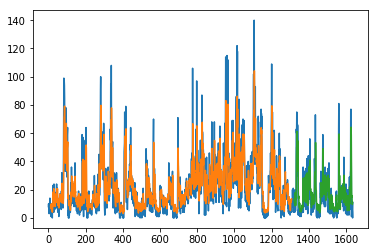

In [29]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()